# Connect Colab to Google Drive

In [ ]:
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive/My Drive/[2024-2025] AN2DL/Homework 1

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).
/gdrive/My Drive/[2024-2025] AN2DL/Homework 1


In [ ]:
!pip install keras_cv

# Import Libraries

In [ ]:
# Set seed for reproducibility
seed = 42

# Import necessary libraries
import os

# Set environment variables before importing modules
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
os.environ['PYTHONHASHSEED'] = str(seed)
os.environ['MPLCONFIGDIR'] = os.getcwd() + '/configs/'

# Suppress warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=Warning)

# Import necessary modules
import logging
import random
import numpy as np

from sklearn.ensemble import IsolationForest


# Set seeds for random number generators in NumPy and Python
np.random.seed(seed)
random.seed(seed)

# Import TensorFlow and Keras
import tensorflow as tf
from tensorflow import keras as tfk
from tensorflow.keras import layers as tfkl
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import EfficientNetV2B0
from tensorflow.keras import models
import keras_cv

# Set seed for TensorFlow
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)

# Reduce TensorFlow verbosity
tf.autograph.set_verbosity(0)
tf.get_logger().setLevel(logging.ERROR)
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

# Print TensorFlow version
print(tf.__version__)

# Import other libraries
import cv2
from tensorflow.keras.applications.mobilenet import preprocess_input
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix
from PIL import Image
import matplotlib.gridspec as gridspec
import requests
from io import BytesIO
import pandas as pd

# Configure plot display settings
sns.set(font_scale=1.4)
sns.set_style('white')
plt.rc('font', size=14)
%matplotlib inline

2.17.1


# Load Data

In [ ]:
data = np.load("training_set.npz")

X = data['images']
y = data['labels']
y = pd.DataFrame(y)

print("We have",X.shape[0],"images with shape",X.shape[1:3],"(RGB images,",X.shape[-1],"channels)")

input_shape = X.shape[1:]
print("Input shape:",input_shape)


We have 13759 images with shape (96, 96) (RGB images, 3 channels)
Input shape: (96, 96, 3)


# Inspect data


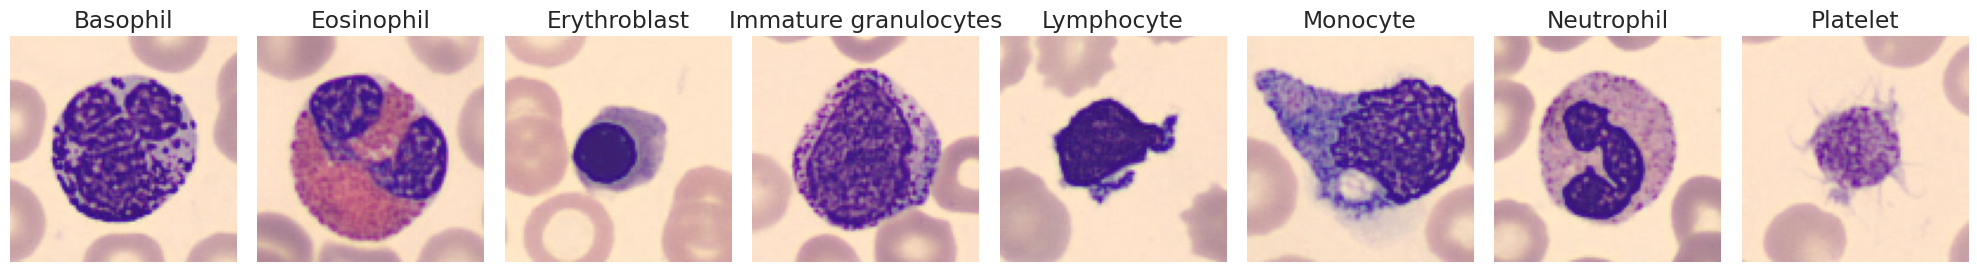

In [ ]:
# Display a sample of images from the training-validation dataset
num_img = len(np.unique(y))

random_indices = []

# Select one random image per class
for label in range(num_img):
    class_indices = y.index[y.iloc[:, 0] == label].tolist()
    random_indices.append(random.choice(class_indices))

labels = {0:'Basophil', 1:'Eosinophil', 2:'Erythroblast', 3:'Immature granulocytes', 4:'Lymphocyte', 5:'Monocyte', 6:'Neutrophil', 7:'Platelet'}
fig, axes = plt.subplots(1, num_img, figsize=(20, 20))

# Iterate through the selected number of images
for i, idx in enumerate(random_indices):
    ax = axes[i % num_img]
    ax.imshow(np.squeeze(X[idx]), vmin=0., vmax=1.)
    ax.set_title(f'{labels[y.iloc[idx][0]]}')
    ax.axis('off')

# Adjust layout and display the images
plt.tight_layout()
plt.show()


In [ ]:
image_stats = []
for image in X:
    mean = np.mean(image)
    std = np.std(image)
    median = np.median(image)
    minimum = np.min(image)
    maximum = np.max(image)
    percentile_25 = np.percentile(image, 25)
    percentile_75 = np.percentile(image, 75)

    image_stats.append([mean, std, median, minimum, maximum, percentile_25, percentile_75])

image_stats = np.array(image_stats)

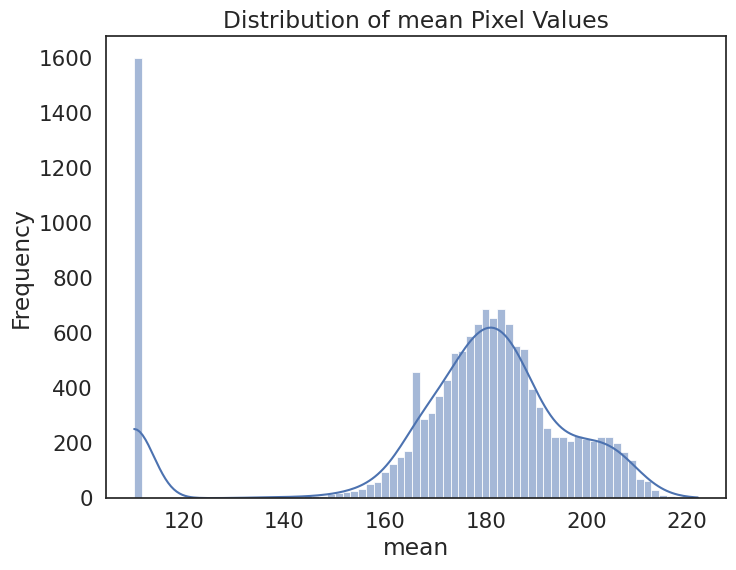

In [ ]:
plt.figure(figsize=(8, 6))
sns.histplot(image_stats[:, 0], kde=True)
plt.title('Distribution of mean Pixel Values')
plt.xlabel('mean')
plt.ylabel('Frequency')
plt.show()

In [ ]:
class_indices = {}
print(labels.items())
for label_index, label_name in labels.items():
    class_indices[label_name] = y.index[y.iloc[:, 0] == label_index].tolist()

dict_items([(0, 'Basophil'), (1, 'Eosinophil'), (2, 'Erythroblast'), (3, 'Immature granulocytes'), (4, 'Lymphocyte'), (5, 'Monocyte'), (6, 'Neutrophil'), (7, 'Platelet')])


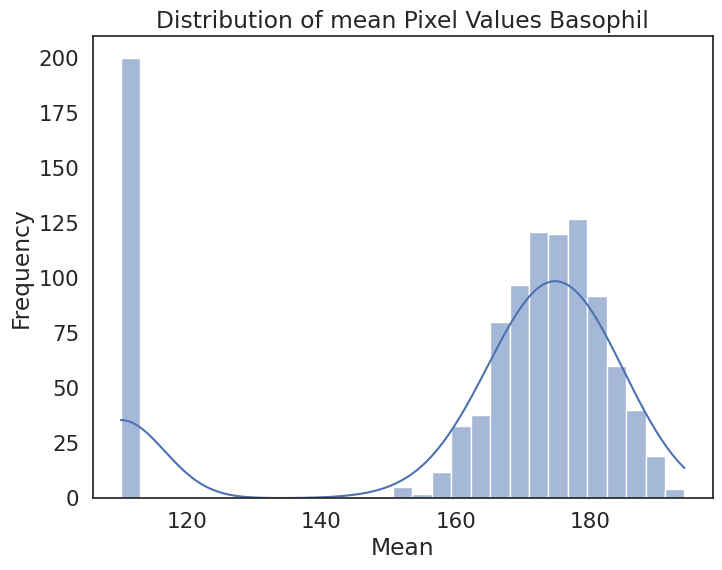

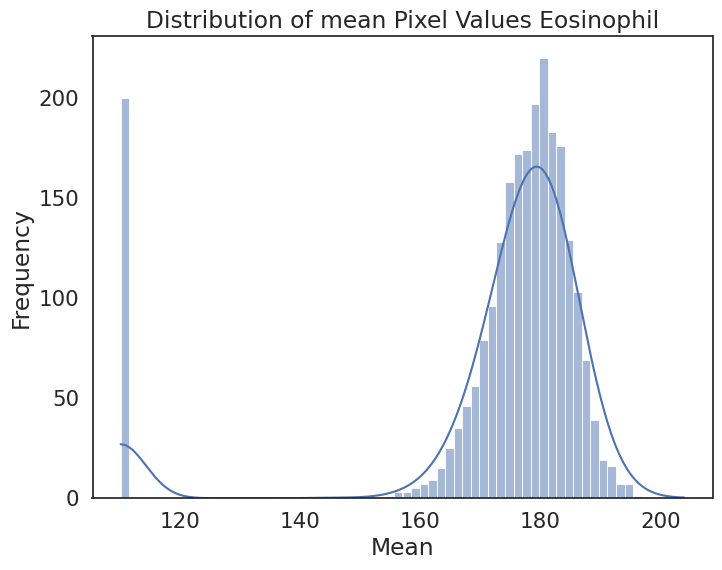

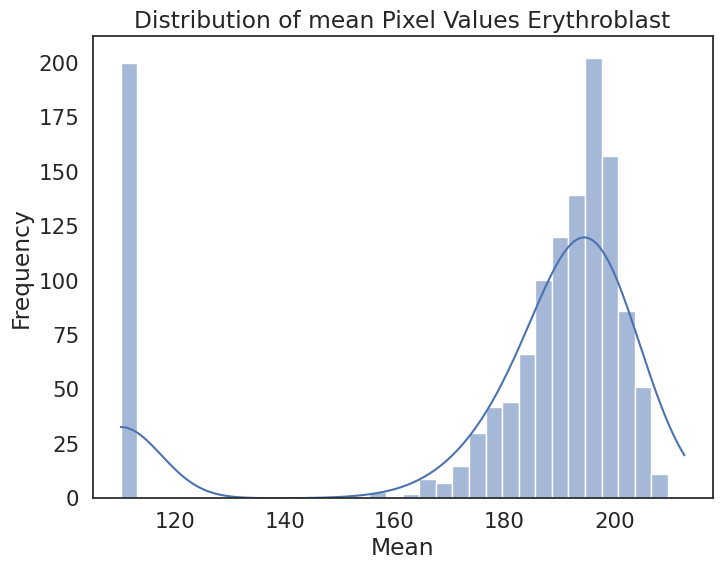

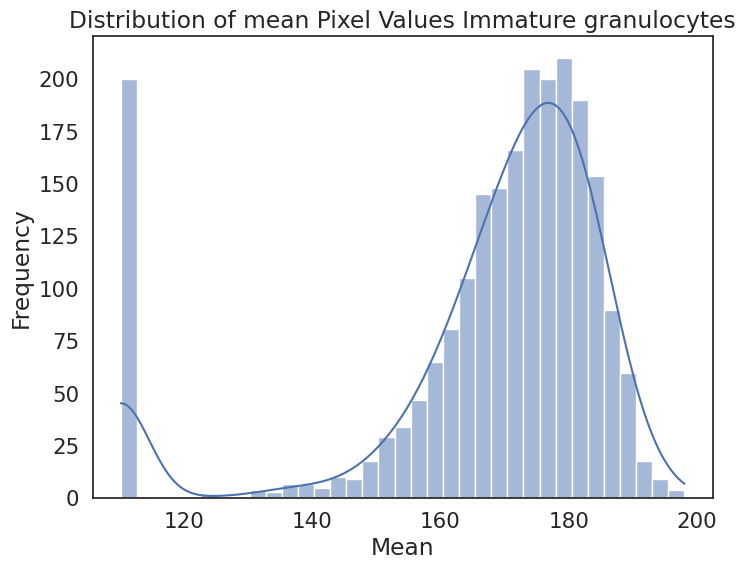

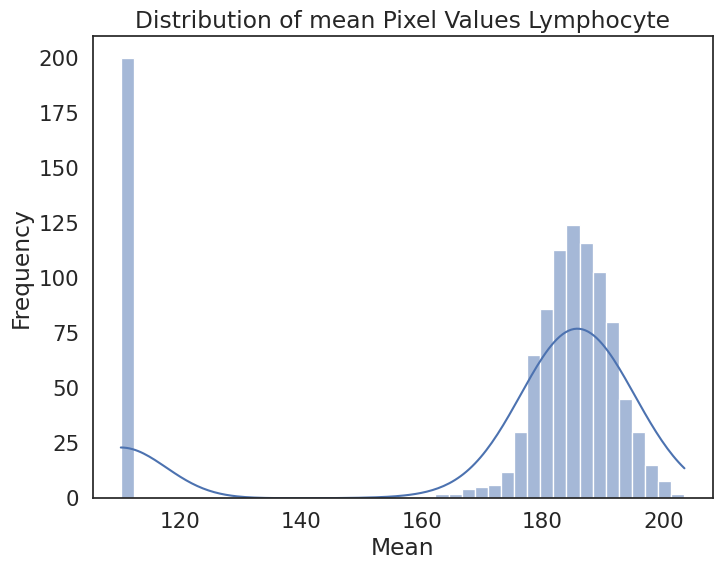

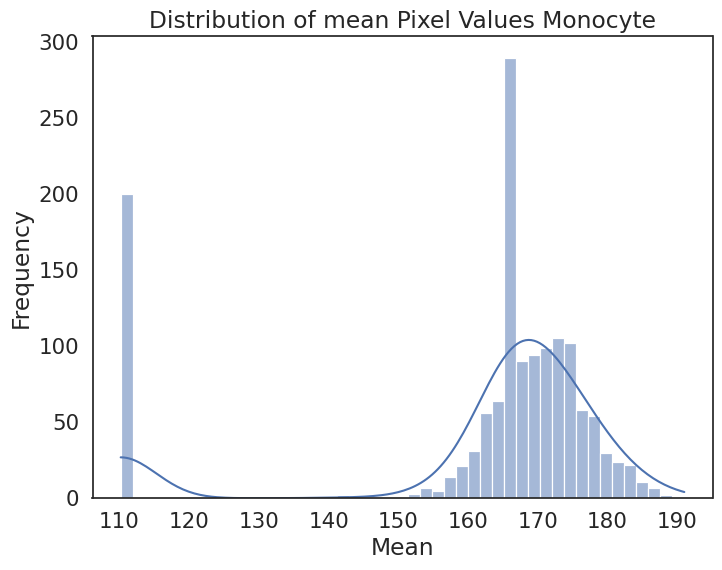

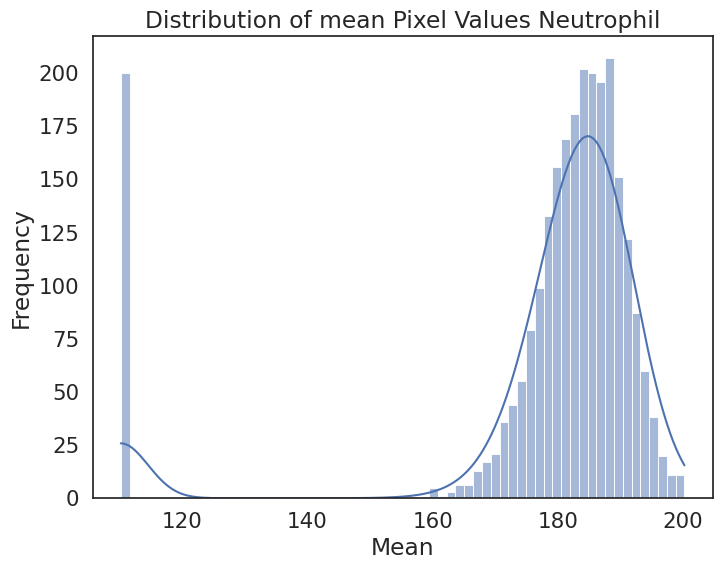

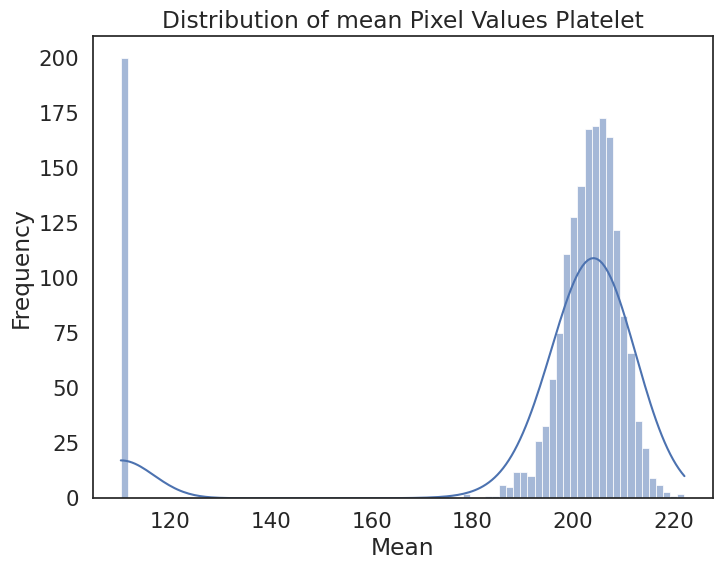

[11959, 11960, 11961, 11962, 11963, 11964, 11965, 11966, 11967, 11968, 11969, 11970, 11971, 11972, 11973, 11974, 11975, 11976, 11977, 11978, 11979, 11980, 11981, 11982, 11983, 11984, 11985, 11986, 11987, 11988, 11989, 11990, 11991, 11992, 11993, 11994, 11995, 11996, 11997, 11998, 11999, 12000, 12001, 12002, 12003, 12004, 12005, 12006, 12007, 12008, 12009, 12010, 12011, 12012, 12013, 12014, 12015, 12016, 12017, 12018, 12019, 12020, 12021, 12022, 12023, 12024, 12025, 12026, 12027, 12028, 12029, 12030, 12031, 12032, 12033, 12034, 12035, 12036, 12037, 12038, 12039, 12040, 12041, 12042, 12043, 12044, 12045, 12046, 12047, 12048, 12049, 12050, 12051, 12052, 12053, 12054, 12055, 12056, 12057, 12058, 12059, 12060, 12061, 12062, 12063, 12064, 12065, 12066, 12067, 12068, 12069, 12070, 12071, 12072, 12073, 12074, 12075, 12076, 12077, 12078, 12079, 12080, 12081, 12082, 12083, 12084, 12085, 12086, 12087, 12088, 12089, 12090, 12091, 12092, 12093, 12094, 12095, 12096, 12097, 12098, 12099, 12100, 12101

In [ ]:
# List to store original outlier indices
outlier_indices_mean = []
image_stats = {}

for label_name, label_indices in class_indices.items():
    X_class = X[label_indices]
    image_stats[label_name] = []

    for image in X_class:
        mean = np.mean(image)
        std = np.std(image)
        median = np.median(image)
        minimum = np.min(image)
        maximum = np.max(image)
        percentile_25 = np.percentile(image, 25)
        percentile_75 = np.percentile(image, 75)
        image_stats[label_name].append([mean, std, median, minimum, maximum, percentile_25, percentile_75])

    image_stats[label_name] = np.array(image_stats[label_name])
    mean_threshold = np.mean(image_stats[label_name][:, 0])
    std_threshold = np.std(image_stats[label_name][:, 0])

    # Get outlier indices within the current class
    outlier_indices_class = np.where(np.abs(image_stats[label_name][:, 0] - mean_threshold) > 1.5 * std_threshold)[0]

    # Map class-specific outlier indices to original indices in X
    for outlier_index in outlier_indices_class:
        original_index = label_indices[outlier_index]
        outlier_indices_mean.append(original_index)

    plt.figure(figsize=(8, 6))
    sns.histplot(image_stats[label_name][:, 0], kde=True)
    plt.title('Distribution of mean Pixel Values ' + label_name)
    plt.xlabel('Mean')
    plt.ylabel('Frequency')
    plt.show()

# outlier_indices_original now contains the original indices of outliers in X
print(outlier_indices_mean)
print(len(outlier_indices_mean))

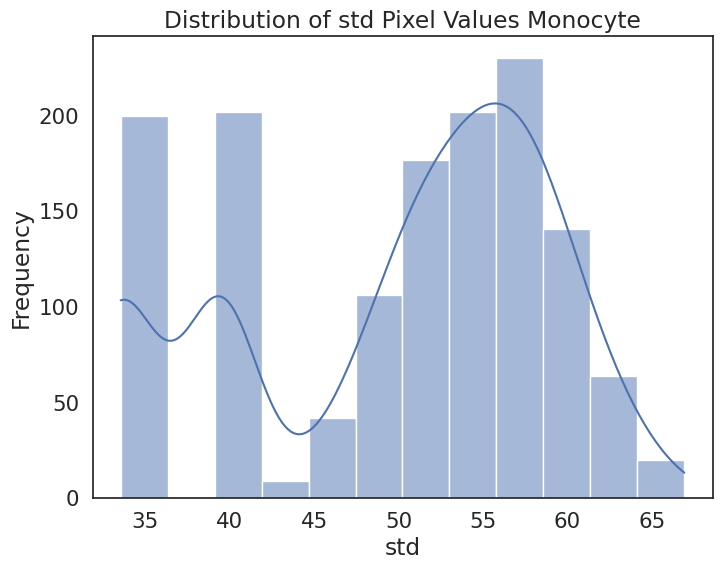

In [ ]:

plt.figure(figsize=(8, 6))
sns.histplot(image_stats['Monocyte'][:, 1], kde=True)
plt.title('Distribution of std Pixel Values Monocyte' )
plt.xlabel('std')
plt.ylabel('Frequency')
plt.show()

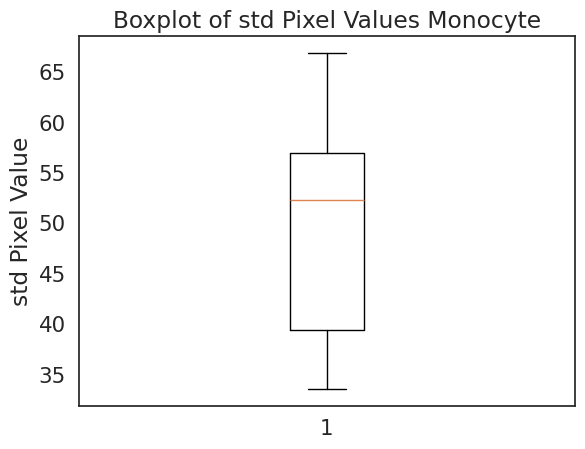

In [ ]:
plt.figure()
plt.boxplot(image_stats['Monocyte'][:, 1])
plt.title('Boxplot of std Pixel Values Monocyte')
plt.ylabel('std Pixel Value')
plt.show()

In [ ]:
# Extract the desired feature data
feature_data = image_stats['Monocyte'][:, 1]
monocyte_indices = np.where(y.iloc[:, 0] == 5)[0]

# Calculate quartiles and IQR
Q1 = np.percentile(feature_data, 25)
Q3 = np.percentile(feature_data, 75)
print(Q1)
filtered_indices = np.where((feature_data < Q1) )[0]
outlier_indices_monocyte = monocyte_indices[filtered_indices]


39.45827720939765


In [ ]:
outlier_indices = np.concatenate((outlier_indices_mean, outlier_indices_monocyte))

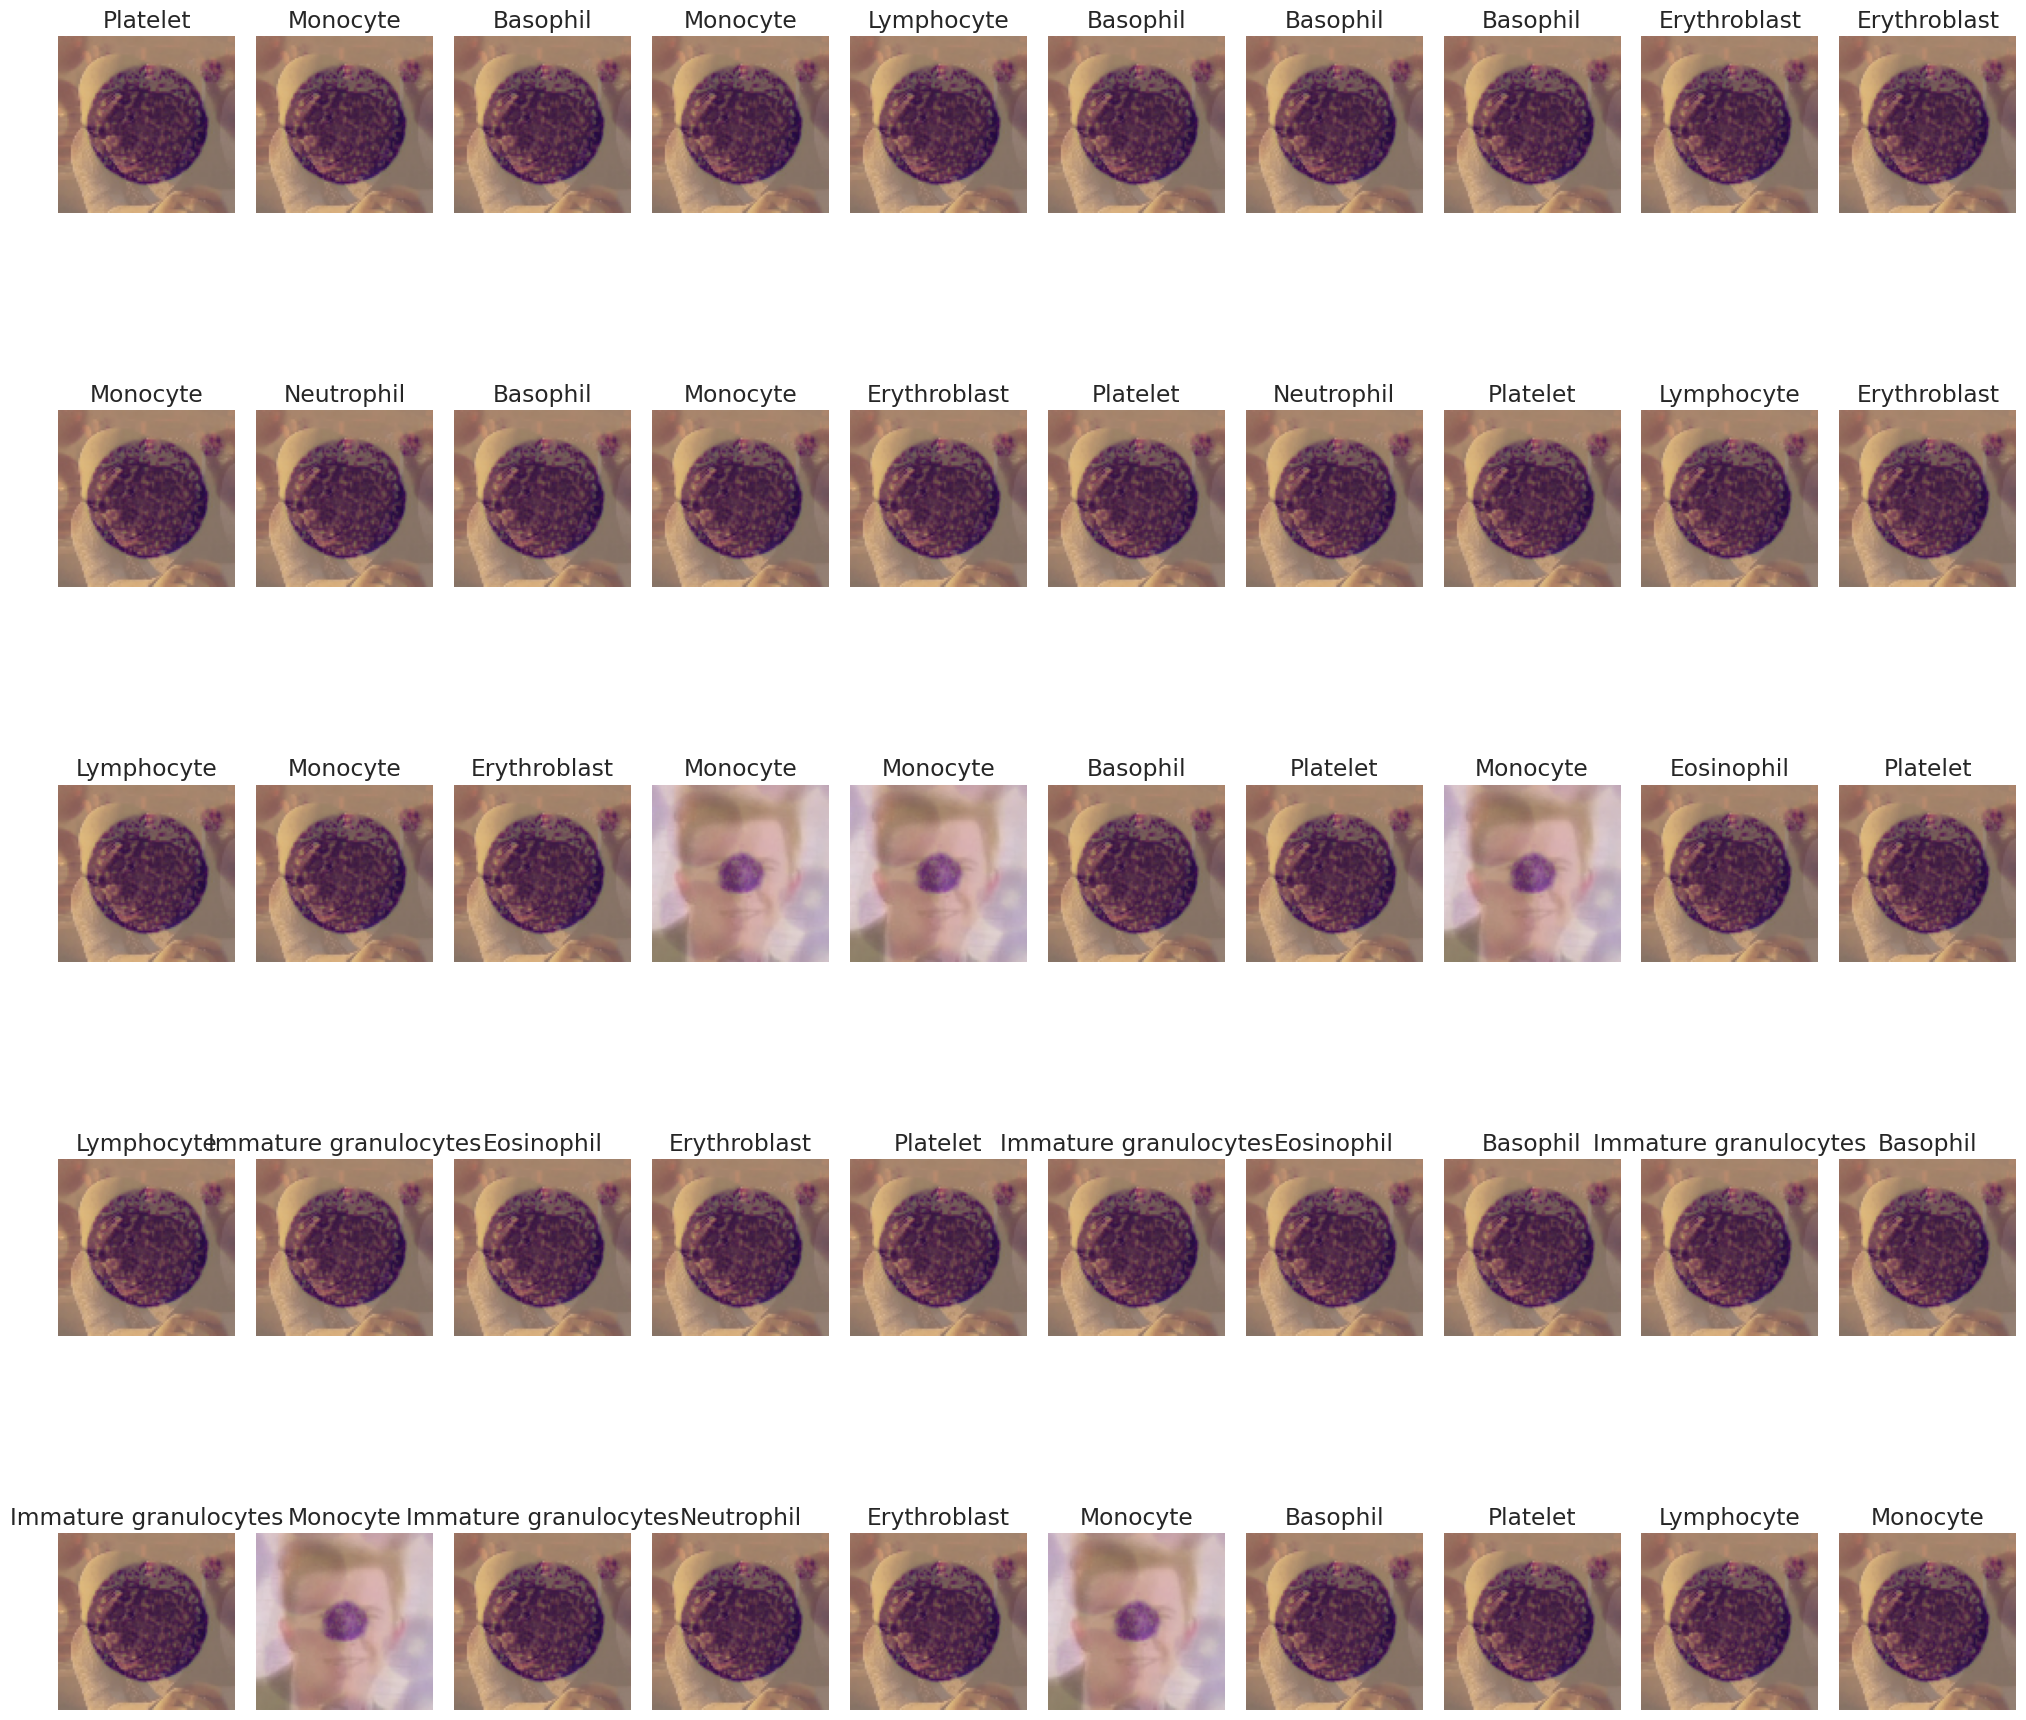

In [ ]:
# Number of outlier images to display
num_outliers_to_display = 50


# Randomly select outlier indices for display
# If you have fewer than 500 outliers, it will display all of them
selected_outlier_indices = random.sample(list(outlier_indices), min(num_outliers_to_display, len(outlier_indices)))



# Calculate the grid dimensions based on the number of images
num_cols = 10  # Number of columns in the grid
num_rows = (num_outliers_to_display + num_cols - 1) // num_cols  # Number of rows

# Create a figure and axes for the plots
fig, axes = plt.subplots(num_rows, num_cols, figsize=(20, 20))
axes = axes.flatten()  # Flatten the axes array for easier indexing

# Iterate through the selected outlier indices and plot the images
for i, outlier_index in enumerate(selected_outlier_indices):
    ax = axes[i]  # Access the current subplot axes
    ax.imshow(np.squeeze(X[outlier_index]), vmin=0., vmax=1.)
    ax.set_title(f'{labels[y.iloc[outlier_index][0]]}')
    ax.axis('off')

# Hide any unused subplots
for i in range(len(selected_outlier_indices), num_rows * num_cols):
    axes[i].axis('off')  # Hide the subplot

# Adjust layout and display the images
plt.tight_layout()
plt.show()

In [ ]:
X = np.delete(X, outlier_indices, axis=0)

y = np.delete(y, outlier_indices, axis=0)

print (X.shape[0])

11946


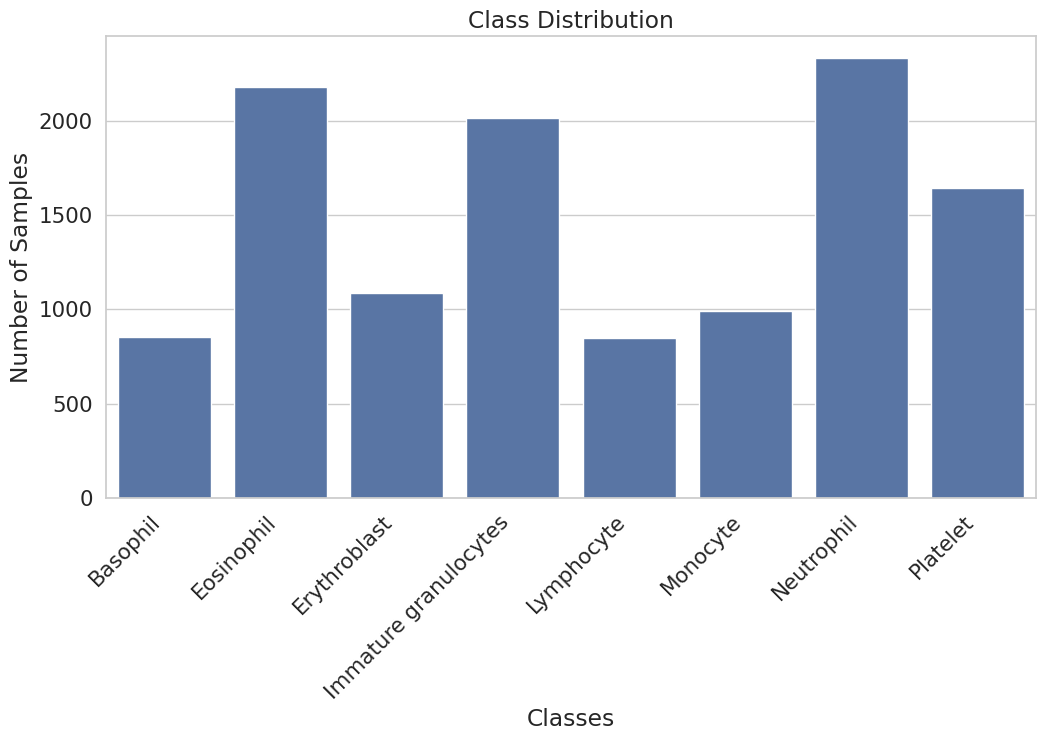

In [ ]:
def plot_class_distribution(y, labels):
    """Plots the class distribution of a dataset.

    Args:
        y: The labels of the dataset.
        labels: A dictionary mapping class indices to class names.
    """
    class_counts = np.bincount(y[:, 0])
    class_names = list(labels.values())

    sns.set_style("whitegrid")
    plt.figure(figsize=(12, 6))
    sns.barplot(x=class_names, y=class_counts)
    plt.title("Class Distribution")
    plt.xlabel("Classes")
    plt.ylabel("Number of Samples")
    plt.xticks(rotation=45, ha='right')
    plt.show()

plot_class_distribution(y, labels)

# Augmentation data

In [ ]:
def augment_dataset_maintain_distribution(X, y, augmentation_factor=2):
    """Augments the dataset while maintaining the original class distribution, given an augmentation factor.

    Args:
        X: The input images.
        y: The corresponding labels.
        augmentation_factor: The factor by which to increase the dataset size.

    Returns:
        X_augmented: The augmented input images.
        y_augmented: The augmented labels.
    """
    X_augmented = []
    y_augmented = []

    # KerasCV RandAugment policy for diverse augmentations
    rand_augment = keras_cv.layers.RandAugment(
        value_range=(0, 255),
        augmentations_per_image=3,
        magnitude=0.5,
        magnitude_stddev=0.2,
        rate=0.5
    )

    # Standard ImageDataGenerator augmentations
    datagen = ImageDataGenerator(
        rotation_range=20,
        width_shift_range=0.2,
        zoom_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest'
    )

    for image, label in zip(X, y):
        for _ in range(augmentation_factor):
            # Apply RandAugment and standard augmentations
            augmented_image = rand_augment(image)
            augmented_image = next(datagen.flow(np.expand_dims(augmented_image, axis=0), batch_size=1))[0]

            X_augmented.append(augmented_image)
            y_augmented.append(label)

    X_augmented = np.array(X_augmented)
    y_augmented = np.array(y_augmented)

    return np.concatenate([X, X_augmented]), np.concatenate([y, y_augmented])


X_augmented, y_augmented = augment_dataset_maintain_distribution(X, y, augmentation_factor=2)

In [ ]:
save_path = 'augmented_data_x3.npz'
np.savez_compressed(save_path, X_augmented=X_augmented, y_augmented=y_augmented)

In [ ]:
data = np.load("augmented_data_x3.npz")

X = data['X_augmented']
y = data['y_augmented']
y = pd.DataFrame(y)


In [ ]:
X=X_augmented
y=y_augmented

In [ ]:
print(X.shape)
print(y.shape)

(35838, 96, 96, 3)
(35838, 1)


# Split training, validation, test

In [ ]:
# Validation set = 20% of the original dataset
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, random_state=seed, test_size=0.2, stratify=y)
# Testing set = 10% of the original dataset
X_train, X_val, y_train, y_val = train_test_split(
    X_train_val,
    y_train_val,
    test_size = len(X_test),
    random_state=seed,
    stratify=y_train_val
)

# Print shapes of the datasets
print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"X_val shape: {X_val.shape}, y_val shape: {y_val.shape}")
print(f"X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")

X_train shape: (21502, 96, 96, 3), y_train shape: (21502, 1)
X_val shape: (7168, 96, 96, 3), y_val shape: (7168, 1)
X_test shape: (7168, 96, 96, 3), y_test shape: (7168, 1)


In [ ]:
unique, count = np.unique(y_train, return_counts=True)

# Convert unique values to integers
unique_int = unique.astype(int)
for i, u in enumerate(unique_int):
    print(labels[u], count[i])

# The dataset is unbalanced

Basophil 1534
Eosinophil 3924
Erythroblast 1953
Immature granulocytes 3625
Lymphocyte 1528
Monocyte 1787
Neutrophil 4194
Platelet 2957


In [ ]:
def balance_dataset_with_augmentation(X, y):
  """
  Balances the dataset using data augmentation.

  Args:
    X: The input images.
    y: The corresponding labels.

  Returns:
    X_balanced: The balanced input images.
    y_balanced: The balanced labels.
  """

  # Calculate class frequencies
  # Convert y to a 1D numpy array
  y_np = y.ravel()
  unique_classes, class_counts = np.unique(y_np, return_counts=True)
  max_count = max(class_counts)


  # Create an ImageDataGenerator for data augmentation
  datagen = ImageDataGenerator(
      rotation_range=20,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest'
  )

  X_balanced = []
  y_balanced = []

  # Augment data for each class
  for class_index, class_count in zip(unique_classes, class_counts):
    # Calculate number of augmentations needed
    num_augmentations = max_count - class_count

    # Filter images for the current class
    # Use the 1D numpy array for indexing
    class_images = X[y_np == class_index]

    # Augment and append images
    for i in range(num_augmentations):
      # Randomly select an image from the class
      image_index = np.random.randint(0, class_images.shape[0])
      image = class_images[image_index]

      # Reshape image for ImageDataGenerator (add batch dimension)
      image = image.reshape((1,) + image.shape)

      # Generate augmented image
      augmented_image = next(datagen.flow(image, batch_size=1))[0]

      # Append augmented image and label
      X_balanced.append(augmented_image)
      y_balanced.append(class_index)

  # Concatenate original and augmented data
  # Ensure X_balanced has the correct dimensions before concatenating
  X_balanced = np.array(X_balanced)

  # Check if X_balanced is empty. If so, skip concatenation to avoid error
  if X_balanced.size != 0:
    # Check dimensions of X and X_balanced and reshape if necessary
    if X_balanced.ndim != X.ndim:
      # If X_balanced has fewer dimensions, reshape it to match X
      # Assuming the missing dimensions are 1
      new_shape = X_balanced.shape + (1,) * (X.ndim - X_balanced.ndim)
      X_balanced = X_balanced.reshape(new_shape)
    X_balanced = np.concatenate([X, X_balanced])
    y_balanced = np.concatenate([y_np, np.array(y_balanced)])


  return X_balanced, y_balanced

In [ ]:
[X_train, y_train] = balance_dataset_with_augmentation(X_train,y_train)
unique, count = np.unique(y_train, return_counts=True)
for u in unique:
    print(labels[u], count[u])

Basophil 4194
Eosinophil 4194
Erythroblast 4194
Immature granulocytes 4194
Lymphocyte 4194
Monocyte 4194
Neutrophil 4194
Platelet 4194


In [ ]:
# One hot encoding
y_train = tfk.utils.to_categorical(y_train, num_classes=len(labels))
y_val = tfk.utils.to_categorical(y_val, num_classes=len(labels))
y_test = tfk.utils.to_categorical(y_test, num_classes=len(labels))

# Train

In [ ]:
input_shape=X_train.shape[1:]
print(f'Input shape: {input_shape}')
output_shape=y_train.shape[1]
print(f'Output shape: {output_shape}')

Input shape: (96, 96, 3)
Output shape: 8


In [ ]:
base_model = EfficientNetV2B0(weights='imagenet', include_top=False, input_shape=input_shape)

# Display a summary of the model architecture
base_model.summary(expand_nested=True)

# Display model architecture with layer shapes and trainable parameters
tfk.utils.plot_model(base_model, expand_nested=True, show_trainable=True, show_shapes=True, dpi=70)

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
base_model.trainable = False

# Define input layer with shape matching the input images
inputs = tfk.Input(shape=input_shape, name='input_layer')

# Apply data augmentation for training robustness
augmentation = tf.keras.Sequential([
    tfkl.RandomFlip("horizontal", name='random_flip_layer'),
    tfkl.RandomTranslation(0.3,0.3, name='random_translation_layer'),
    tfkl.RandomRotation(0.2, name='random_rotation_layer'),
    tfkl.RandomContrast(0.2, name='random_contrast_layer'),
    tfkl.RandomBrightness(0.2, name='random_brightness_layer')
], name='preprocessing_layer')

x = augmentation(inputs)

# Pass augmented inputs through the EfficientNet feature extractor
x = base_model(x, training=False)

# Add a GlobalAveragePooling2D layer to flatten the spatial dimensions
x = tfkl.GlobalAveragePooling2D(name='global_average_pooling_layer')(x)
x = tfkl.GroupNormalization(name='group_normalization_layer')(x)

# Add a dropout layer for regularisation
x = tfkl.Dropout(0.5, name='dropout_layer')(x)

# Add final Dense layer for classification with softmax activation
outputs = tfkl.Dense(y_train.shape[-1], activation='softmax', name='dense_layer')(x)

# Define the complete model linking input and output
tl_model = tfk.Model(inputs=inputs, outputs=outputs, name='model')

# Display a summary of the model architecture
tl_model.summary(expand_nested=True)

# Print layer indices, names, and trainability status
for i, layer in enumerate(tl_model.layers):
    print(i, layer.name, layer.trainable)

Model: "model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 96, 96, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ preprocessing_layer (Sequential)     │ (None, 96, 96, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ random_flip_layer (RandomFlip)  │ (None, 96, 96, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ random_translation_layer        │ (None, 96, 96, 3)           │               0 │
│ (RandomTranslation)                  │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ random_rotation_layer           │ (None, 96, 96, 3)           │               0 │
│ (RandomRotation)                     │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ random_contrast_layer           │ (None, 96, 96, 3)           │               0 │
│ (RandomContrast)                     │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ random_brightness_layer         │ (None, 96, 96, 3)           │               0 │
│ (RandomBrightness)                   │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ efficientnetv2-b0 (Functional)       │ (None, 3, 3, 1280)          │       5,919,312 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ input_layer (InputLayer)        │ (None, 96, 96, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ rescaling (Rescaling)           │ (None, 96, 96, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ normalization (Normalization)   │ (None, 96, 96, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ stem_conv (Conv2D)              │ (None, 48, 48, 32)          │             864 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ stem_bn (BatchNormalization)    │ (None, 48, 48, 32)          │             128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ stem_activation (Activation)    │ (None, 48, 48, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ block1a_project_conv (Conv2D)   │ (None, 48, 48, 16)          │           4,608 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ block1a_project_bn              │ (None, 48, 48, 16)          │              64 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ block1a_project_activation      │ (None, 48, 48, 16)          │               0 │
│ (Activation)                         │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ block2a_expand_conv (Conv2D)    │ (None, 24, 24, 64)          │           9,216 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 5,932,120 (22.63 MB)

 Trainable params: 12,808 (50.03 KB)

 Non-trainable params: 5,919,312 (22.58 MB)

0 input_layer True
1 preprocessing_layer True
2 efficientnetv2-b0 False
3 global_average_pooling_layer True
4 group_normalization_layer True
5 dropout_layer True
6 dense_layer True


In [ ]:
# Compile the model with categorical cross-entropy loss and Adam optimiser
tl_model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Adam(), metrics=['accuracy'])


In [ ]:
# Train the model
tl_history = tl_model.fit(
    x=X_train,
    y=y_train,
    batch_size=64,
    epochs=50,
    validation_data=(X_val, y_val),
    callbacks=[tfk.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=20, restore_best_weights=True)]
).history

# Calculate and print the best validation accuracy achieved
final_val_accuracy = round(max(tl_history['val_accuracy']) * 100, 2)
print(f'Final validation accuracy: {final_val_accuracy}%')

# Save the trained model to a file, including final accuracy in the filename
model_filename = 'EfficientNetV2B0_' + str(final_val_accuracy) + '.keras'
tl_model.save(model_filename)

Epoch 1/50
525/525 ━━━━━━━━━━━━━━━━━━━━ 25s 24ms/step - accuracy: 0.3639 - loss: 1.9805 - val_accuracy: 0.6992 - val_loss: 0.8857
Epoch 2/50
525/525 ━━━━━━━━━━━━━━━━━━━━ 9s 17ms/step - accuracy: 0.5567 - loss: 1.2487 - val_accuracy: 0.7074 - val_loss: 0.8440
Epoch 3/50
525/525 ━━━━━━━━━━━━━━━━━━━━ 9s 17ms/step - accuracy: 0.5777 - loss: 1.1968 - val_accuracy: 0.7235 - val_loss: 0.8118
Epoch 4/50
525/525 ━━━━━━━━━━━━━━━━━━━━ 9s 17ms/step - accuracy: 0.5761 - loss: 1.1836 - val_accuracy: 0.6989 - val_loss: 0.8673
Epoch 5/50
525/525 ━━━━━━━━━━━━━━━━━━━━ 9s 17ms/step - accuracy: 0.5863 - loss: 1.1675 - val_accuracy: 0.7327 - val_loss: 0.7977
Epoch 6/50
525/525 ━━━━━━━━━━━━━━━━━━━━ 9s 17ms/step - accuracy: 0.5974 - loss: 1.1415 - val_accuracy: 0.7372 - val_loss: 0.7928
Epoch 7/50
525/525 ━━━━━━━━━━━━━━━━━━━━ 9s 17ms/step - accuracy: 0.5869 - loss: 1.1488 - val_accuracy: 0.7340 - val_loss: 0.8009
Epoch 8/50
525/525 ━━━━━━━━━━━━━━━━━━━━ 9s 17ms/step - accuracy: 0.5937 - loss: 1.1445 - val_acc

In [ ]:
# Plot training and validation loss
def plot_loss(history):
  plt.figure(figsize=(10, 2))
  plt.plot(history['loss'], label='Training loss', alpha=.8)
  plt.plot(history['val_loss'], label='Validation loss', alpha=.8)
  plt.title('Loss')
  plt.legend()
  plt.grid(alpha=.3)

# Plot training and validation accuracy
def plot_accuracy(history):
  plt.figure(figsize=(10, 2))
  plt.plot(history['accuracy'], label='Training accuracy', alpha=.8)
  plt.plot(history['val_accuracy'], label='Validation accuracy', alpha=.8)
  plt.title('Accuracy')
  plt.legend()
  plt.grid(alpha=.3)
  plt.show()

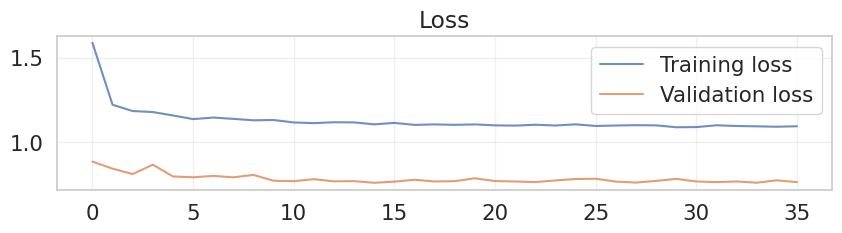

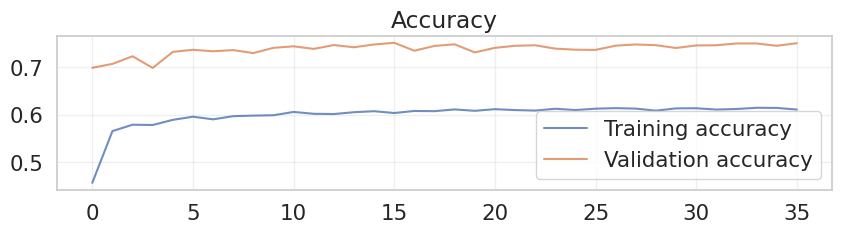

In [ ]:
plot_loss(tl_history)
plot_accuracy(tl_history)

In [ ]:
def plot_confusion_matrix(true_classes, pred_classes, labels, title):
    # Compute the confusion matrix

# Compute the confusion matrix
  cm = confusion_matrix(true_classes, pred_classes)
  cm =  ( cm.astype('float') / cm.sum(axis=1)[:, np.newaxis])*100
# Combine numbers and percentages into a single string for annotation
  annot = np.array([f"{num}" for num in cm.flatten()]).reshape(cm.shape)

# Plot the confusion matrix
  plt.figure(figsize=(10, 8))
  sns.heatmap(cm.T, annot=True, fmt='.2f', xticklabels=list(labels.values()), yticklabels=list(labels.values()), cmap='Blues')
  plt.xlabel('True labels')
  plt.ylabel('Predicted labels')
  plt.title(title)
  plt.show()

Predictions Shape: (7168, 8)
[7 1 2 ... 7 7 3]


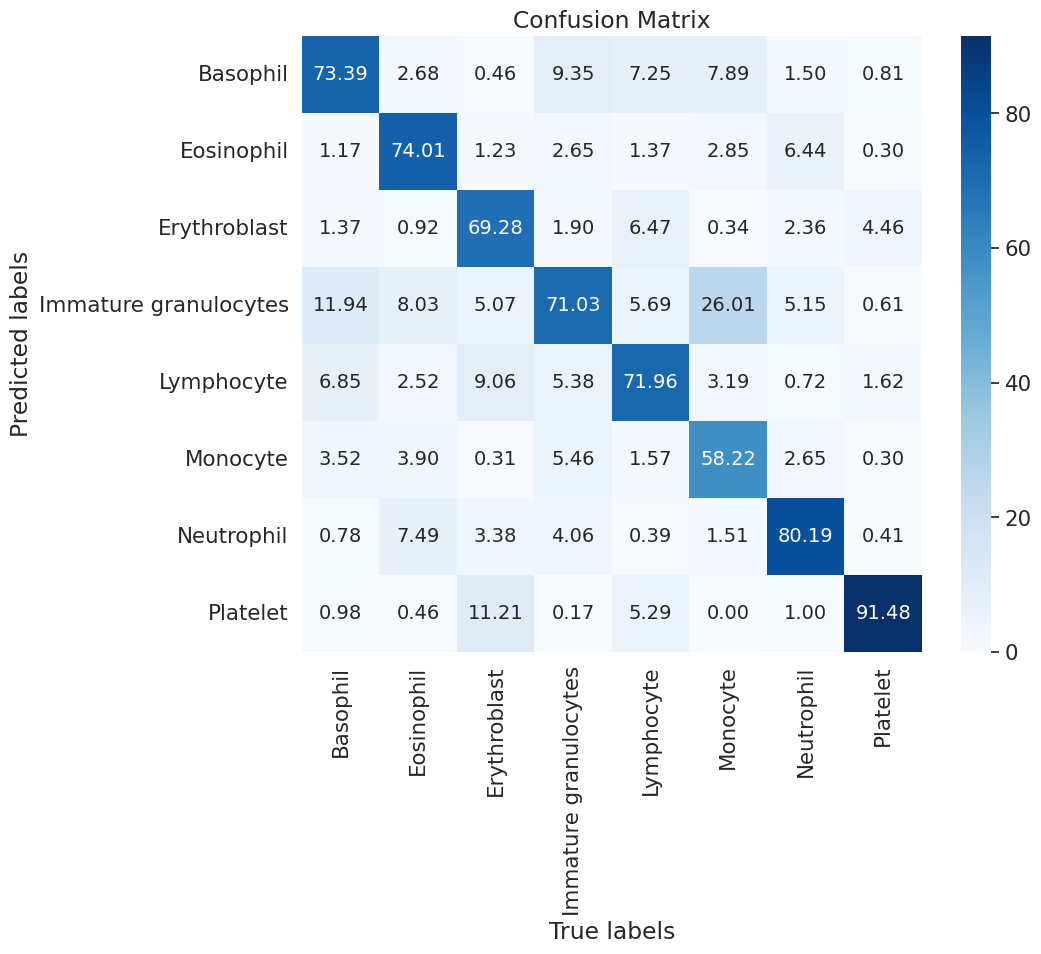

In [ ]:
model = tfk.models.load_model("EfficientNetV2B0_75.18.keras")

predictions=model.predict(X_val, verbose=0)
# Display the shape of the predictions
print("Predictions Shape:", predictions.shape)
predictions_cnn=predictions
pred_classes = np.argmax(predictions, axis=-1)
print(pred_classes)
true_classes = np.argmax(y_val, axis=-1)
plot_confusion_matrix(true_classes, pred_classes, labels, 'Confusion Matrix')

# Fine tuning

In [ ]:
# Re-load the model after transfer learning
ft_model = tfk.models.load_model('EfficientNetV2B0_75.18.keras')

# Set the EfficientNetV2B0 model layers as trainable
ft_model.get_layer('efficientnetv2-b0').trainable = True

# Set all EfficientNetV2B0 layers as non-trainable
for layer in ft_model.get_layer('efficientnetv2-b0').layers:
    layer.trainable = False

# Enable training only for Conv2D and DepthwiseConv2D layers
for i, layer in enumerate(ft_model.get_layer('efficientnetv2-b0').layers):
    if isinstance(layer, tf.keras.layers.Conv2D) or isinstance(layer, tf.keras.layers.DepthwiseConv2D):
        layer.trainable = True
        print(i, layer.name, type(layer).__name__, layer.trainable)

3 stem_conv Conv2D True
6 block1a_project_conv Conv2D True
9 block2a_expand_conv Conv2D True
12 block2a_project_conv Conv2D True
14 block2b_expand_conv Conv2D True
17 block2b_project_conv Conv2D True
21 block3a_expand_conv Conv2D True
24 block3a_project_conv Conv2D True
26 block3b_expand_conv Conv2D True
29 block3b_project_conv Conv2D True
33 block4a_expand_conv Conv2D True
36 block4a_dwconv2 DepthwiseConv2D True
41 block4a_se_reduce Conv2D True
42 block4a_se_expand Conv2D True
44 block4a_project_conv Conv2D True
46 block4b_expand_conv Conv2D True
49 block4b_dwconv2 DepthwiseConv2D True
54 block4b_se_reduce Conv2D True
55 block4b_se_expand Conv2D True
57 block4b_project_conv Conv2D True
61 block4c_expand_conv Conv2D True
64 block4c_dwconv2 DepthwiseConv2D True
69 block4c_se_reduce Conv2D True
70 block4c_se_expand Conv2D True
72 block4c_project_conv Conv2D True
76 block5a_expand_conv Conv2D True
79 block5a_dwconv2 DepthwiseConv2D True
84 block5a_se_reduce Conv2D True
85 block5a_se_expan

In [ ]:
# Set the number of layers to freeze
N = 50

# Set the first N layers as non-trainable
for i, layer in enumerate(ft_model.get_layer('efficientnetv2-b0').layers[:N]):
    layer.trainable = False

# Print layer indices, names, and trainability status
for i, layer in enumerate(ft_model.get_layer('efficientnetv2-b0').layers):
    print(i, layer.name, layer.trainable)

0 input_layer False
1 rescaling False
2 normalization False
3 stem_conv False
4 stem_bn False
5 stem_activation False
6 block1a_project_conv False
7 block1a_project_bn False
8 block1a_project_activation False
9 block2a_expand_conv False
10 block2a_expand_bn False
11 block2a_expand_activation False
12 block2a_project_conv False
13 block2a_project_bn False
14 block2b_expand_conv False
15 block2b_expand_bn False
16 block2b_expand_activation False
17 block2b_project_conv False
18 block2b_project_bn False
19 block2b_drop False
20 block2b_add False
21 block3a_expand_conv False
22 block3a_expand_bn False
23 block3a_expand_activation False
24 block3a_project_conv False
25 block3a_project_bn False
26 block3b_expand_conv False
27 block3b_expand_bn False
28 block3b_expand_activation False
29 block3b_project_conv False
30 block3b_project_bn False
31 block3b_drop False
32 block3b_add False
33 block4a_expand_conv False
34 block4a_expand_bn False
35 block4a_expand_activation False
36 block4a_dwconv2 

In [ ]:
# Compile the model
ft_model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Adam(1e-4), metrics=['accuracy'])

In [ ]:
# Fine-tune the model
ft_history = ft_model.fit(
    x = X_train,
    y = y_train,
    batch_size = 64,
    epochs = 200,
    validation_data = (X_val, y_val),
    callbacks = [tfk.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=10, restore_best_weights=True)]
).history

# Calculate and print the final validation accuracy
final_val_accuracy = round(max(ft_history['val_accuracy'])* 100, 2)
print(f'Final validation accuracy: {final_val_accuracy}%')

# Save the trained model to a file with the accuracy included in the filename
model_filename = 'EfficientNetV2B0_FT_'+str(final_val_accuracy)+'.keras'
ft_model.save(model_filename)

# Delete the model to free up resources
del ft_model

Epoch 1/200
525/525 ━━━━━━━━━━━━━━━━━━━━ 49s 49ms/step - accuracy: 0.7440 - loss: 0.7393 - val_accuracy: 0.9060 - val_loss: 0.2806
Epoch 2/200
525/525 ━━━━━━━━━━━━━━━━━━━━ 22s 42ms/step - accuracy: 0.8622 - loss: 0.3990 - val_accuracy: 0.9279 - val_loss: 0.2188
Epoch 3/200
525/525 ━━━━━━━━━━━━━━━━━━━━ 22s 42ms/step - accuracy: 0.8931 - loss: 0.3089 - val_accuracy: 0.9415 - val_loss: 0.1815
Epoch 4/200
525/525 ━━━━━━━━━━━━━━━━━━━━ 22s 42ms/step - accuracy: 0.9050 - loss: 0.2736 - val_accuracy: 0.9418 - val_loss: 0.1802
Epoch 5/200
525/525 ━━━━━━━━━━━━━━━━━━━━ 25s 47ms/step - accuracy: 0.9161 - loss: 0.2473 - val_accuracy: 0.9438 - val_loss: 0.1780
Epoch 6/200
525/525 ━━━━━━━━━━━━━━━━━━━━ 25s 48ms/step - accuracy: 0.9211 - loss: 0.2316 - val_accuracy: 0.9545 - val_loss: 0.1414
Epoch 7/200
525/525 ━━━━━━━━━━━━━━━━━━━━ 25s 48ms/step - accuracy: 0.9289 - loss: 0.2096 - val_accuracy: 0.9588 - val_loss: 0.1190
Epoch 8/200
525/525 ━━━━━━━━━━━━━━━━━━━━ 25s 48ms/step - accuracy: 0.9310 - loss: 0

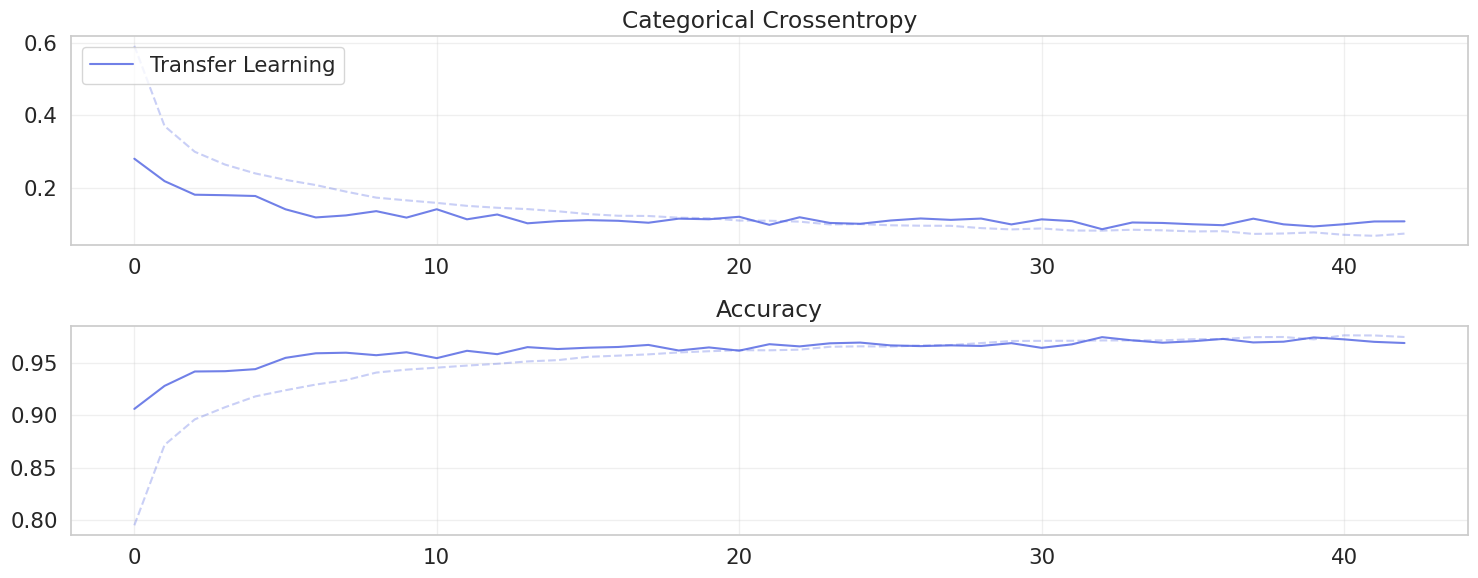

In [ ]:
# Create figure and subplots for loss and accuracy
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 6))

# Plot loss
ax1.plot(ft_history['loss'], alpha=0.3, color='#4D61E2', linestyle='--')
ax1.plot(ft_history['val_loss'], label='Transfer Learning', alpha=0.8, color='#4D61E2')
ax1.set_title('Categorical Crossentropy')
ax1.legend(loc='upper left')
ax1.grid(alpha=0.3)

# Plot accuracy
ax2.plot(ft_history['accuracy'], alpha=0.3, color='#4D61E2', linestyle='--')
ax2.plot(ft_history['val_accuracy'], label='Transfer Learning', alpha=0.8, color='#4D61E2')
ax2.set_title('Accuracy')
ax2.grid(alpha=0.3)

# Adjust layout to prevent label overlap and display the plots
plt.tight_layout()
plt.show()

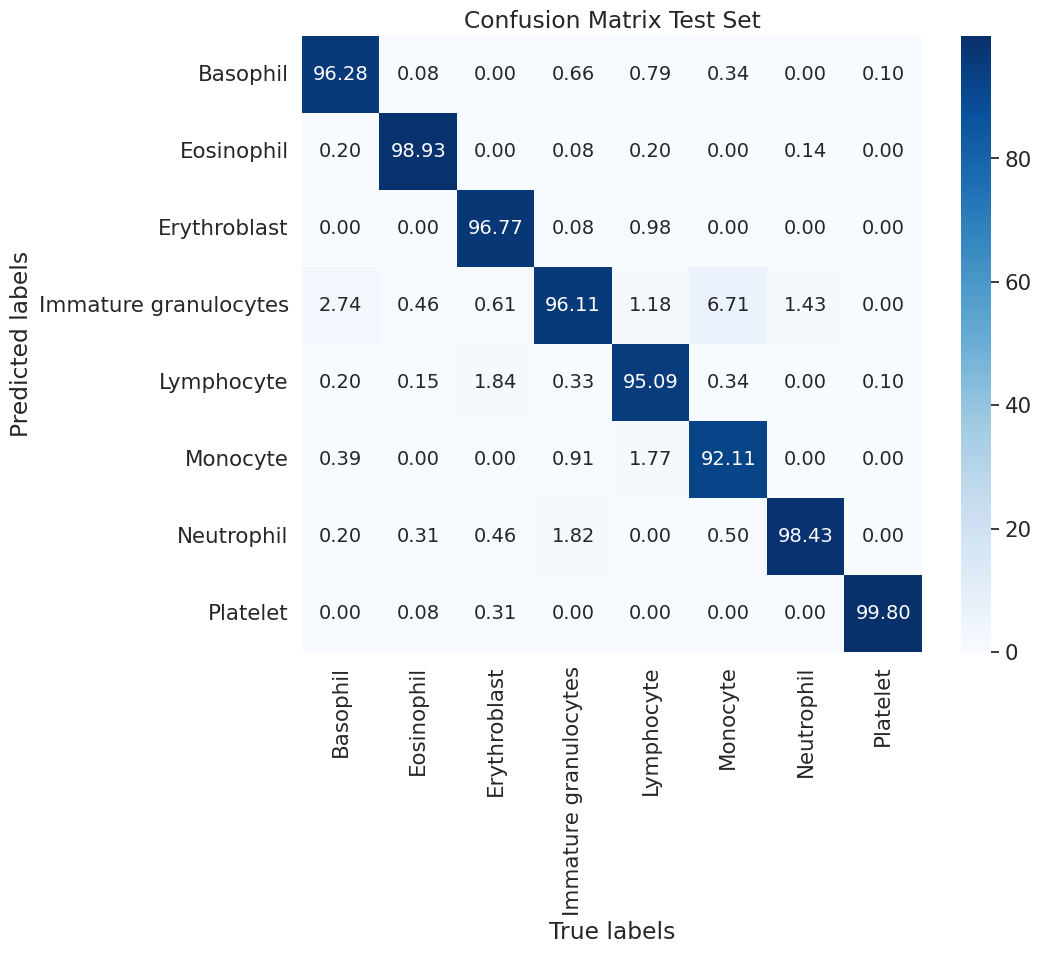

In [ ]:
model = tfk.models.load_model("EfficientNetV2B0_FT_97.42.keras")

predictions=model.predict(X_test, verbose=0)
# Display the shape of the predictions

predictions_cnn=predictions
pred_classes = np.argmax(predictions, axis=-1)

true_classes = np.argmax(y_test, axis=-1)
plot_confusion_matrix(true_classes, pred_classes, labels, 'Confusion Matrix Test Set')